## Imports

In [2]:
import numpy as np
import pandas as pd

import torch
from torch import nn
import torch.nn.functional as F
from torchinfo import summary

from nltk.tokenize import word_tokenize
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from tqdm.notebook import tqdm
sns.set_style("darkgrid")

## Upload Data

In [3]:
train_df = pd.read_csv("data/twitter_training.csv", header=None)
val_df = pd.read_csv("data/twitter_training.csv", header=None)

## First Look

In [4]:
train_df.head(3)

,0,1,2,3
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...


* We only need second and third columns in this case

In [5]:
train_df, val_df = train_df[[2,3]], val_df[[2,3]]
train_df.columns, val_df.columns = ["sentiment", "tweet"], ["sentiment", "tweet"]

## Drop Missing Values

In [6]:
train_df.isnull().sum()

sentiment      0
tweet        686
dtype: int64

In [7]:
print(f"{round(686/train_df.shape[0], 2)}% of Train data is missing")

0.01% of Train data is missing


In [8]:
train_df.dropna(axis=0, inplace=True)

## Explanatory Data Analysis

#### Check Target Variable Distribution

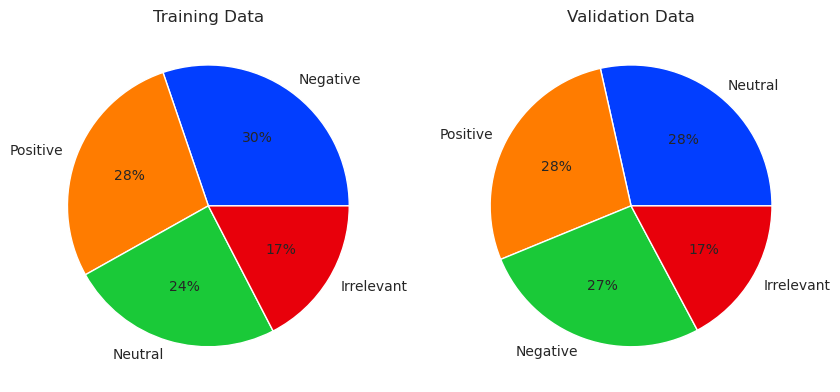

In [9]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10,8))

axes[0].pie(list(train_df["sentiment"].value_counts()), labels=list(train_df["sentiment"].value_counts().index),
            colors=sns.color_palette('bright'), autopct='%.0f%%')
axes[0].set_title("Training Data")

axes[1].pie(list(val_df["sentiment"].value_counts()), labels=list(val_df["sentiment"].value_counts().index),
            colors=sns.color_palette('bright'), autopct='%.0f%%')
axes[1].set_title("Validation Data")
plt.show()

* Seems classes are quite balances both in training and validation data

#### Check "Irrelevant" Class

In [10]:
for idx, twt in enumerate(train_df.loc[train_df["sentiment"]=="Irrelevant", "tweet"]):
    print(twt)
    print("--------")
    if idx==10:
        break

Appreciate the (sonic) concepts / praxis Valenzuela and Landa-Posas thread together in this talk: multimodal listening, soundwalks, borderlands frameworks, participatory action research, and testimonios. . . So many thoughtful and resonant intersections here.. .  
--------
Appreciate the (sound) concepts / practices that Valenzuela and Landa-Posas combine in this lecture: multimodal listening, soundwalks, borderland frameworks, participatory action research and testimonies... So many thoughtful and resonant intersections here...
--------
Evaluate the (sound) concepts / concepts of Valensela and Landa Pozas together in this conversation: multimodal listening, walks, border areas, joint action studies, etc. So many amazing and resonant intersections here...
--------
Appreciate the (sonic) concepts / praxis Valenzuela and Moreno-Posas have together in this talk: multimodal listening, soundwalks, borderlands recordings, participatory field research, and testimonios.... So many thoughtful a

* These tweets does not have any meaning; I want this dataset to check how small encoder based transformer will work it, so for demonstration purpose I thick leaving three main classes and delete this "Ittelevant" tweets should be a good idea. 

#### Drop "Irrelevant" Class

In [11]:
train_df = train_df.loc[train_df["sentiment"]!="Irrelevant"]
val_df = val_df.loc[val_df["sentiment"]!="Irrelevant"]

#### Check Length of Tokenized Tweets

In [12]:
train_df["length"] = train_df["tweet"].apply(lambda x: len(word_tokenize(x)))
val_df["length"] = train_df["tweet"].apply(lambda x: len(word_tokenize(x)))

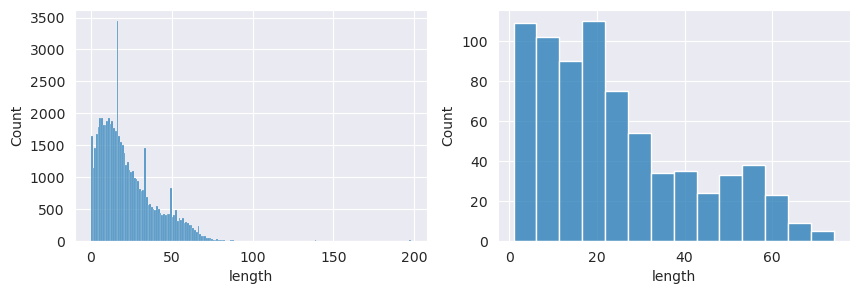

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(10,3))

sns.histplot(ax=axes[0], x=train_df["length"])
sns.histplot(ax=axes[1], x=val_df["length"])

plt.show()

* Seems 80 should be more than enough for max sequence length

## Data Preprocess

#### Tokenize Tweets

In [15]:
idx2class = {clas: idx for idx,clas in enumerate(list(train_df["sentiment"].unique()))}
class2idx = {idx: clas for idx,clas in enumerate(list(train_df["sentiment"].unique()))}
print(idx2class)
print(class2idx)

{'Positive': 0, 'Neutral': 1, 'Negative': 2}
{0: 'Positive', 1: 'Neutral', 2: 'Negative'}


In [16]:
X_train, y_train = [], []
X_val, y_val = [], []

for idx, (st, tw) in train_df[["sentiment", "tweet"]].iterrows():
    X_train.append(word_tokenize(tw))
    y_train.append(idx2class[st])

for idx, (st, tw) in val_df[["sentiment", "tweet"]].iterrows():
    X_val.append(word_tokenize(tw))
    y_val.append(idx2class[st])

In [17]:
counter = Counter()
for i in range(len(X_train)):
    counter.update([str(wr).lower() for wr in X_train[i]])

In [18]:
counter = Counter()
for i in range(len(X_train)):
    counter.update([str(wr).lower() for wr in X_train[i]])
print(f"Number of all unique tokens in Train Data: {len(counter)}")

Number of all unique tokens in Train Data: 35349


In [19]:
# define padding and unknown tokens
PAD = 0
UNK = 1
# define maximum tweet length and vocabulary size
vocab_size = 10000
max_seq_length = 80

In [20]:
most_common_words = np.array(counter.most_common(vocab_size - 2))
vocab = most_common_words[:,0]
word2id = {vocab[i]: i + 2 for i in range(len(vocab))}

In [24]:
counter.most_common(20)

[('.', 56665),
 ('the', 36463),
 ('i', 30409),
 (',', 25956),
 ('@', 24436),
 ('!', 24099),
 ('to', 23914),
 ('and', 21925),
 ('a', 19352),
 ('of', 15807),
 ('is', 14837),
 ('it', 14771),
 ('for', 12646),
 ('in', 12574),
 ('/', 12399),
 ('this', 12028),
 ('?', 11099),
 ('you', 10058),
 ('...', 10013),
 ('my', 9958)]

* In this case my goal is to detect sentiment given tweet and as punctuation marks and stop words could be important in sentence, I will not remove any of them and let the model to handle it.

#### Encode Tokens

In [25]:
def Word2IntEncoder(data, max_seq_length, word2id, PAD, UNK):
    encoded_data = []
    for idx, ls in enumerate(data):
        emb = []
        # if string contains more than max_seq_length, take first max_seq_length token
        if len(ls)>max_seq_length:
            ls = ls[:max_seq_length]
        # if word is in dictionary, encode it, if not: append UNK token
        for i in range(len(ls)):
            if ls[i] in word2id:
                emb.append(word2id[ls[i]])
            else:
                emb.append(UNK)
        # fill short tweets to PAD token
        if len(emb)<max_seq_length:
            emb = emb + [PAD] * (max_seq_length-len(emb))
        
        encoded_data.append(emb)
    return encoded_data

In [26]:
X_train_encoded = Word2IntEncoder(X_train, max_seq_length, word2id, PAD, UNK)
X_val_encoded = Word2IntEncoder(X_val, max_seq_length, word2id, PAD, UNK)
len(X_train_encoded), len(X_val_encoded)

(61121, 828)

#### Generate X & y Matrices

In [27]:
X_train, y_train = torch.Tensor(X_train_encoded).long(), torch.Tensor(y_train).long()
X_val, y_val = torch.Tensor(X_val_encoded).long(), torch.Tensor(y_val).long()
X_train.shape, y_train.shape, X_val.shape, y_val.shape

(torch.Size([61121, 80]),
 torch.Size([61121]),
 torch.Size([828, 80]),
 torch.Size([828]))

#### Define Dataset & DataLoaders for Batch Processing

In [28]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [29]:
train_dataset = MyDataset(data=X_train, labels=y_train)
val_dataset = MyDataset(data=X_val, labels=y_val)

In [30]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=828, shuffle=False)

In [31]:
for n_batch, (x, y) in enumerate(train_loader):
    print(n_batch)
    print(x.shape)
    print(y.shape)
    break
for n_batch, (x_val, y_val) in enumerate(val_loader):
    print(n_batch)
    print(x_val.shape)
    print(y_val.shape)
    break

0
torch.Size([128, 80])
torch.Size([128])
0
torch.Size([828, 80])
torch.Size([828])


## Model Building

#### Model Parameters

In [32]:
vocab_size=10000      # number of word in vocabulary
max_seq_length = 80   # maximum tweet length (length of tokenized tweet) (T)
d_emb = 100           # dimension of embedding vector
head_size = 20        # head size of self-attention 
num_heads = 6         # number of heads in multi-head self-attenton
n_layer = 3           # number of encoder blocks in model
dropout= 0.3          # dropout rate
num_classes = 3       # number of target classes

#### Device

In [33]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#### Embadding Class

In [34]:
class MainEmbadding(nn.Module):
    def __init__(self, vocab_size, d_emb, max_seq_length):
        super().__init__()
        self.word_emb = nn.Embedding(vocab_size, d_emb) # (vocab_size,d_emb)
        self.pos_emb = nn.Embedding(max_seq_length, d_emb) # (T,d_emb)
        self.max_seq_length = max_seq_length
        
    def forward(self, x):
        emb1 = self.word_emb(x) # (B,T,d_emb)
        emb2 = self.pos_emb(torch.arange(self.max_seq_length, device=device)) # (T,d_emb)
        
        return emb1+emb2 #  (B,T,d_emb)

#### Define Single Self-Attention Head

In [35]:
class Head(nn.Module):
    def __init__(self, head_size, d_emb, dropout=dropout):
        super().__init__()
        self.d_embed = d_emb # 20
        self.head_size = head_size # 16
        self.q = nn.Linear(d_emb, head_size, bias=False) # weight dims: (head_size, d_emb)
        self.k = nn.Linear(d_emb, head_size, bias=False) # weight dims: (head_size, d_emb)
        self.v = nn.Linear(d_emb, head_size, bias=False) # weight dims: (head_size, d_emb)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        query = self.q(x) # (B,T,head_size)
        key   = self.k(x) # (B,T,head_size)
        value = self.v(x) # (B,T,head_size)
        
        wei = torch.matmul(query, key.transpose(-1,-2)) * self.head_size**-0.5 # (B,T,head_size) @ (B,head_size,T) -> (B,T,T)
        wei = F.softmax(wei, dim=-1)
        wei = self.dropout(wei)
        
        out = torch.matmul(wei, value) # (B,T,T) @ (B,T,head_size) -> (B,T,head_size)
        return out

#### Define Multi-Head Self-Attention

In [36]:
class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads, head_size, d_emb, dropout=dropout):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size, d_emb) for _ in range(num_heads)]) # (B,T,head_size)
        self.proj = nn.Linear(head_size * num_heads, d_emb) # (B,T,d_emb)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out # (B,T,d_emb)

#### FeedForward Layer for Encoder Block

In [37]:
class FeedFoward(nn.Module):
    def __init__(self, d_emb, dropout=dropout):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d_emb, 4 * d_emb),
            nn.ReLU(),
            nn.Linear(4 * d_emb, d_emb),
            nn.Dropout()
        )

    def forward(self, x):
        return self.net(x) # (B,T,d_emb)

#### Build Single Transformer Encoder Block

In [38]:
class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, d_emb, num_heads):
        super().__init__()
        head_size = d_emb // num_heads
        self.sa = MultiHeadAttention(num_heads, head_size, d_emb)
        self.ffwd = FeedFoward(d_emb)
        self.ln1 = nn.LayerNorm(d_emb)
        self.ln2 = nn.LayerNorm(d_emb)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x # (B,T,d_emb)

#### Define FinalLayer for Classification

In [39]:
class FinalLayer(nn.Module):
    def __init__(self, d_emb, max_seq_length, num_classes):
        super().__init__()
        self.final_layer = nn.Linear(d_emb * max_seq_length, num_classes)
    
    def forward(self, x):
        x_flattened = torch.flatten(x, start_dim=1) # (B,T*C)
        unscaled_out = self.final_layer(x_flattened)
        probs = F.softmax(unscaled_out, dim=1)
        return probs # (B,num_classes)

#### Build TransformerClassifier 

In [40]:
class TransformerClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.embadding = MainEmbadding(vocab_size=vocab_size, d_emb=d_emb, max_seq_length=max_seq_length)
        self.blocks = nn.Sequential(*[Block(d_emb, num_heads=num_heads) for _ in range(n_layer)])
        self.final_layer = FinalLayer(d_emb=d_emb, max_seq_length=max_seq_length, num_classes=num_classes)
    
    def forward(self, x):
        x_emb = self.embadding(x)
        features = self.blocks(x_emb)
        probs = self.final_layer(features)
        return probs

#### Define Model & Check Weights

In [41]:
transformer = TransformerClassifier().to(device)

In [42]:
summary(transformer, input_data=x.to(device).long())

Layer (type:depth-idx)                        Output Shape              Param #
TransformerClassifier                         [128, 3]                  --
├─MainEmbadding: 1-1                          [128, 80, 100]            --
│    └─Embedding: 2-1                         [128, 80, 100]            1,000,000
│    └─Embedding: 2-2                         [80, 100]                 8,000
├─Sequential: 1-2                             [128, 80, 100]            --
│    └─Block: 2-3                             [128, 80, 100]            --
│    │    └─LayerNorm: 3-1                    [128, 80, 100]            200
│    │    └─MultiHeadAttention: 3-2           [128, 80, 100]            38,500
│    │    └─LayerNorm: 3-3                    [128, 80, 100]            200
│    │    └─FeedFoward: 3-4                   [128, 80, 100]            80,500
│    └─Block: 2-4                             [128, 80, 100]            --
│    │    └─LayerNorm: 3-5                    [128, 80, 100]            200

#### Training

#### Define l

In [43]:
num_epochs = 100
lr_rate = 3e-4 # Karpathy Constant

In [47]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=transformer.parameters(), lr=lr_rate)

In [45]:
accuracy_stats = {"train": [],
                  "val": []}
loss_stats = {"train": [],
              "val": []}

#### Trainig Loop

In [76]:
for n_epoch in range(20):
    transformer.train()
    train_epoch_loss = 0
    train_epoch_acc = 0

    for n_batch, (x, y) in enumerate(train_loader):
        x = x.long().to(device)
        y = y.long().to(device)

        probs = transformer(x) # make prediction
        preds = probs.argmax(axis=1)

        loss = criterion(probs, y) # calculate loss

        optimizer.zero_grad() # nullify gradients
        loss.backward() # do backpropagation
        optimizer.step() # update weights

        train_acc = ((preds == y).sum()/y.shape[0]).item()

        train_epoch_loss+=loss
        train_epoch_acc+=train_acc

    transformer.eval()
    with torch.no_grad():
        for n_batch, (x, y) in enumerate(val_loader):
            x = x.to(device)
            y = y.to(device)
            probs = transformer(x)
            preds = probs.argmax(axis=1)

            val_loss = criterion(probs, y)
            val_acc = ((preds == y).sum()/y.shape[0]).item()


    loss_stats['train'].append(float(train_epoch_loss/len(train_loader)))
    loss_stats['val'].append(float(val_loss))
    accuracy_stats['train'].append(float(train_epoch_acc/len(train_loader)))
    accuracy_stats['val'].append(float(val_acc))
  
    print(f'Epoch {n_epoch+1}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_loss:.5f} | Train Acc: {train_epoch_acc/len(train_loader):.4f} | Val Acc: {val_acc:.4f}')

## Visualize Results

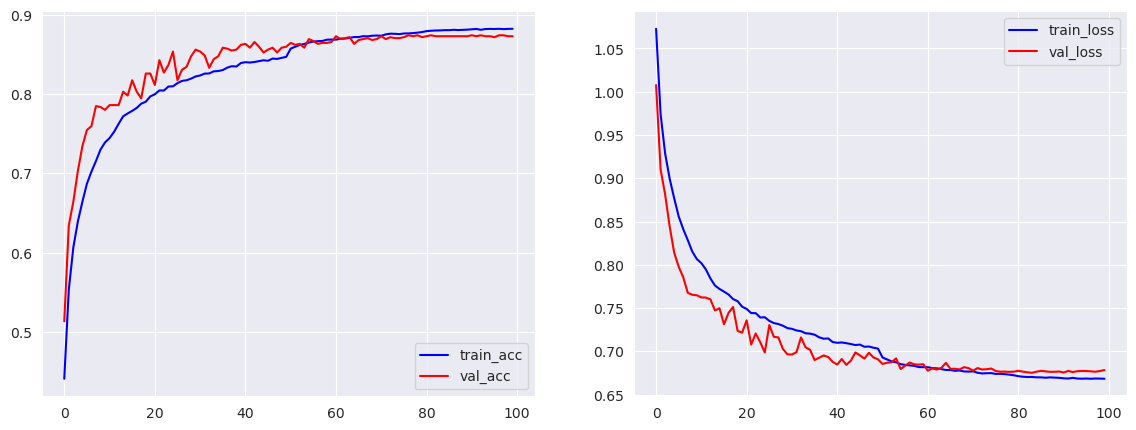

In [79]:
fig, axes = plt.subplots(1, 2, figsize=(14,5))

axes[0].plot(list(range(len(accuracy_stats['train']))), accuracy_stats['train'],label="train_acc", color="b")
axes[0].plot(list(range(len(accuracy_stats['val']))), accuracy_stats['val'],label="val_acc",color="r")
axes[0].legend()

axes[1].plot(list(range(len(loss_stats['train']))), loss_stats['train'],label="train_loss",color="b")
axes[1].plot(list(range(len(loss_stats['val']))), loss_stats['val'],label="val_loss",color="r")
axes[1].legend()
plt.show()

In [80]:
for n_batch, (x_val, y_val) in enumerate(val_loader):
    x_val = x_val.long().to(device)
    transformer.eval()
    with torch.no_grad():
        val_preds = torch.argmax(transformer(x_val), dim=1)

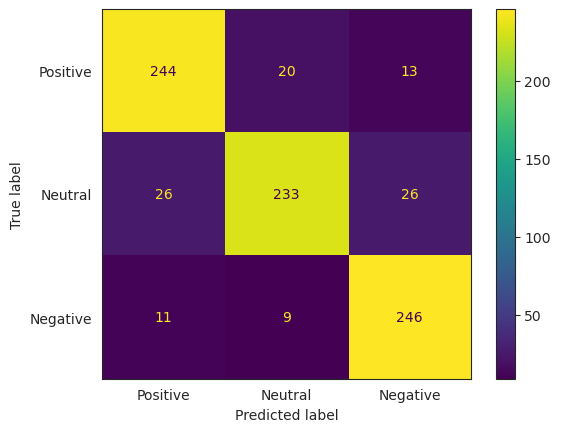

In [81]:
sns.set_style("white")
disp = ConfusionMatrixDisplay(confusion_matrix(y_val.to("cpu").numpy(), val_preds.to("cpu").numpy()),
                              display_labels=["Positive", "Neutral", "Negative"])
disp.plot()
plt.show()

In [82]:
val_df["preds"] = val_preds.to("cpu").numpy()
val_df["preds_class"] = val_df["preds"].apply(lambda x: class2idx[x])

In [83]:
count = 0
for idx, (st, tw, prd) in val_df.loc[val_df["sentiment"]!=val_df["preds_class"]][["sentiment", "tweet", "preds_class"]].iterrows():
    print(f"\033[1mOriginal Sentiment\033[0m: {st}, \033[1mPredicted Sentiment\033[0m: {prd}")
    print("\033[1mTweet\033[0m")
    print(tw)
    print("-----------------------------------------------------------------")
    count += 1
    if count == 7:
        break

Original Sentiment: Positive, Predicted Sentiment: Neutral
Tweet
Thank you @EAMaddenNFL!! 

New TE Austin Hooper in the ORANGE & BROWN!! 

#Browns | @AustinHooper18 

 pic.twitter.com/GRg4xzFKOn
-----------------------------------------------------------------
Original Sentiment: Positive, Predicted Sentiment: Negative
Tweet
my ass still knee-deep in Assassins Creed Odyssey with no way out anytime soon lmao
-----------------------------------------------------------------
Original Sentiment: Negative, Predicted Sentiment: Neutral
Tweet
FIX IT JESUS ! Please FIX IT ! What In the world is going on here.  @PlayStation @AskPlayStation @Playstationsup @Treyarch @CallofDuty negative 345 silver wolf error code pic.twitter.com/ziRyhrf59Q
-----------------------------------------------------------------
Original Sentiment: Positive, Predicted Sentiment: Neutral
Tweet
Itching to assassinate 

#TCCGif #AssassinsCreedBlackFlag #AssassinsCreed #TheCapturedCollective pic.twitter.com/vv8MOGtCjw
-----

#### Save Model Weights & Vocabulary

In [86]:
torch.save(transformer.state_dict(), "weights.pt")

In [87]:
np.save("vocab.npy", most_common_words)